In [ ]:
# prep data

# a) import the libraries we need
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# install non-standard libraries (XGBoost and CatBoost)
!pip install xgboost catboost -qq

import xgboost as xgb
from catboost import CatBoostClassifier

# improve display
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
np.set_printoptions(suppress=True, precision=4)

# b) load the dataset
df = pd.read_csv('Social_Network_Ads_Classification (2).csv')

X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

# c) split the train set and the test set, with random_state=0, test_size=0.2
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0
)

print(f"Train samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

# d) apply feature scaling (standard scaler)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

print("\nData preparation complete.")
print("X_train (Scaled) snippet:\n", X_train[:5])

Train samples: 320
Test samples: 80

Data preparation complete.
X_train (Scaled) snippet:
 [[ 1.923   2.146 ]
 [ 2.0202  0.3787]
 [-1.3822 -0.4325]
 [-1.1878 -1.0119]
 [ 1.923  -0.925 ]]


In [ ]:
# 2) train the models

# a) use train set as the input of GridSearchCV to find the best parameters

# dictionary to store all models and their parameter grids
models_and_params = {
    'Logistic Regression': (
        LogisticRegression(random_state=0, solver='liblinear'),
        {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2']}
    ),
    'KNN': (
        KNeighborsClassifier(p=2, metric='minkowski'),
        {'n_neighbors': [3, 5, 7, 9, 11], 'weights': ['uniform', 'distance']}
    ),
    'SVC (LinearSVC)': (
        LinearSVC(random_state=0, dual=True, max_iter=10000),
        {'C': [0.1, 1, 10, 100]}
    ),
    'Kernel SVC (RBF)': (
        SVC(random_state=0),
        {'C': [0.1, 1, 10], 'kernel': ['rbf', 'poly'], 'gamma': ['scale', 'auto']}
    ),
    'Decision Tree': (
        DecisionTreeClassifier(random_state=0),
        {'criterion': ['gini', 'entropy'], 'max_depth': [3, 5, 7, None]}
    ),
    'Random Forest': (
        RandomForestClassifier(random_state=0),
        {'n_estimators': [50, 100, 200], 'criterion': ['gini', 'entropy'], 'max_depth': [5, 10, None]}
    ),
    'Naive Bayes': (
        GaussianNB(),
        {'var_smoothing': np.logspace(0, -9, num=100)}
    ),
    'XGBoost': (
        xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=0),
        {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1], 'max_depth': [3, 6]}
    ),
    'CatBoost': (
        CatBoostClassifier(verbose=0, random_state=0),
        {'iterations': [100, 200], 'learning_rate': [0.05, 0.1], 'depth': [4, 6]}
    )
}

best_estimators = {}

print("Starting GridSearchCV for all 9 models...\n")

for name, (model, params) in models_and_params.items():
    print(f" Tuning {name} ")

    grid_search = GridSearchCV(
        estimator=model,
        param_grid=params,
        scoring='accuracy',
        cv=5,
        n_jobs=-1
    )

    # fit the grid search to the training data
    grid_search.fit(X_train, y_train)

    # store the best estimator
    best_estimators[name] = grid_search.best_estimator_

    print(f"  Best Parameters: {grid_search.best_params_}")
    print(f"  Best Cross-Validated Accuracy: {grid_search.best_score_:.4f}\n")

print("GridSearchCV complete for all models.")

Starting GridSearchCV for all 9 models...

 Tuning Logistic Regression 
  Best Parameters: {'C': 0.1, 'penalty': 'l1'}
  Best Cross-Validated Accuracy: 0.8406

 Tuning KNN 
  Best Parameters: {'n_neighbors': 5, 'weights': 'distance'}
  Best Cross-Validated Accuracy: 0.9062

 Tuning SVC (LinearSVC) 
  Best Parameters: {'C': 1}
  Best Cross-Validated Accuracy: 0.8250

 Tuning Kernel SVC (RBF) 
  Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
  Best Cross-Validated Accuracy: 0.9000

 Tuning Decision Tree 
  Best Parameters: {'criterion': 'gini', 'max_depth': 3}
  Best Cross-Validated Accuracy: 0.8906

 Tuning Random Forest 
  Best Parameters: {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 100}
  Best Cross-Validated Accuracy: 0.9031

 Tuning Naive Bayes 
  Best Parameters: {'var_smoothing': np.float64(0.002848035868435802)}
  Best Cross-Validated Accuracy: 0.8812

 Tuning XGBoost 


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [06:48:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  Best Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
  Best Cross-Validated Accuracy: 0.9062

 Tuning CatBoost 
  Best Parameters: {'depth': 6, 'iterations': 100, 'learning_rate': 0.1}
  Best Cross-Validated Accuracy: 0.9062

GridSearchCV complete for all models.


In [ ]:
#  3) evaluate the model

def evaluate_model(name, model, X_train, y_train, X_test, y_test):
    """Calculates and prints confusion matrix and classification report for a model."""

    # predict on  training set
    y_train_pred = model.predict(X_train)

    # predict on the test set
    y_test_pred = model.predict(X_test)

    print(f"\n{'='*50}\nModel: {name}\n{'='*50}")

    # train results
    print("\nTraining Set Evaluation ")
    print(f"Accuracy: {accuracy_score(y_train, y_train_pred):.4f}")
    print("\nConfusion Matrix (Train):\n", confusion_matrix(y_train, y_train_pred))
    print("\nClassification Report (Train):\n", classification_report(y_train, y_train_pred, zero_division=0))

    # test results
    print("\nTest Set Evaluation")
    print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
    print("\nConfusion Matrix (Test):\n", confusion_matrix(y_test, y_test_pred))
    print("\nClassification Report (Test):\n", classification_report(y_test, y_test_pred, zero_division=0))

# loop through all best estimators and evaluate
for name, model in best_estimators.items():
    evaluate_model(name, model, X_train, y_train, X_test, y_test)


Model: Logistic Regression

Training Set Evaluation 
Accuracy: 0.8406

Confusion Matrix (Train):
 [[179  20]
 [ 31  90]]

Classification Report (Train):
               precision    recall  f1-score   support

           0       0.85      0.90      0.88       199
           1       0.82      0.74      0.78       121

    accuracy                           0.84       320
   macro avg       0.84      0.82      0.83       320
weighted avg       0.84      0.84      0.84       320


Test Set Evaluation
Accuracy: 0.9125

Confusion Matrix (Test):
 [[55  3]
 [ 4 18]]

Classification Report (Test):
               precision    recall  f1-score   support

           0       0.93      0.95      0.94        58
           1       0.86      0.82      0.84        22

    accuracy                           0.91        80
   macro avg       0.89      0.88      0.89        80
weighted avg       0.91      0.91      0.91        80


Model: KNN

Training Set Evaluation 
Accuracy: 0.9969

Confusion Matrix (T

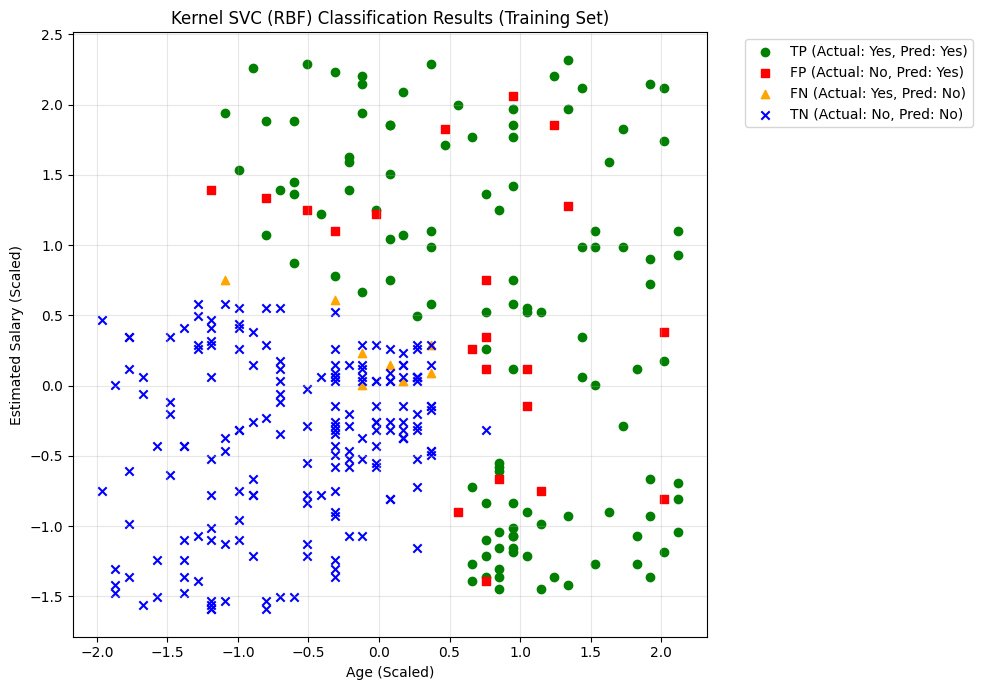

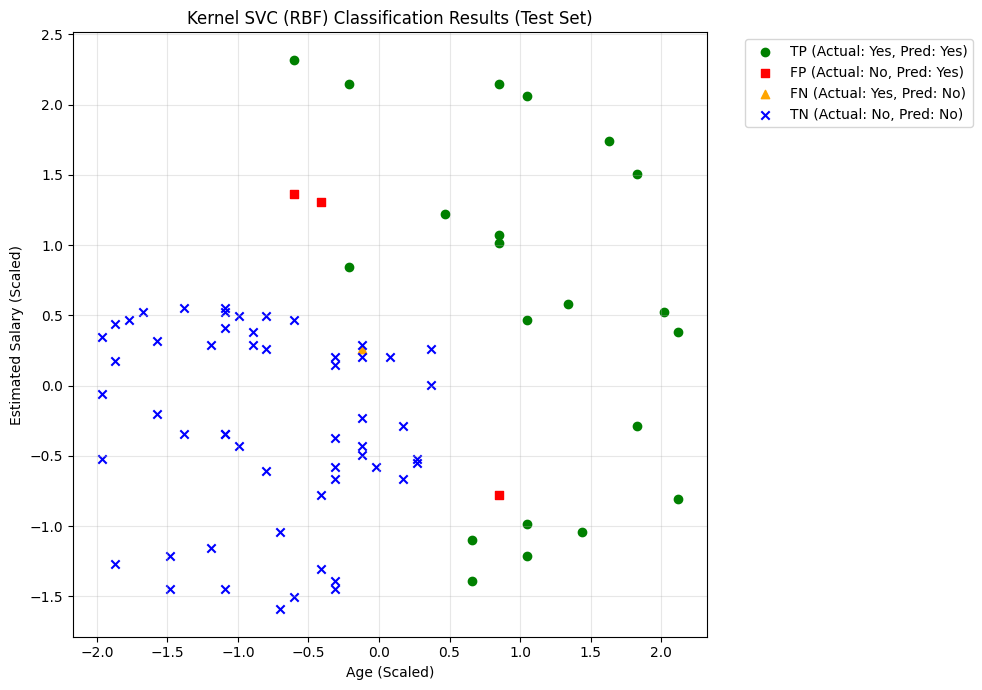

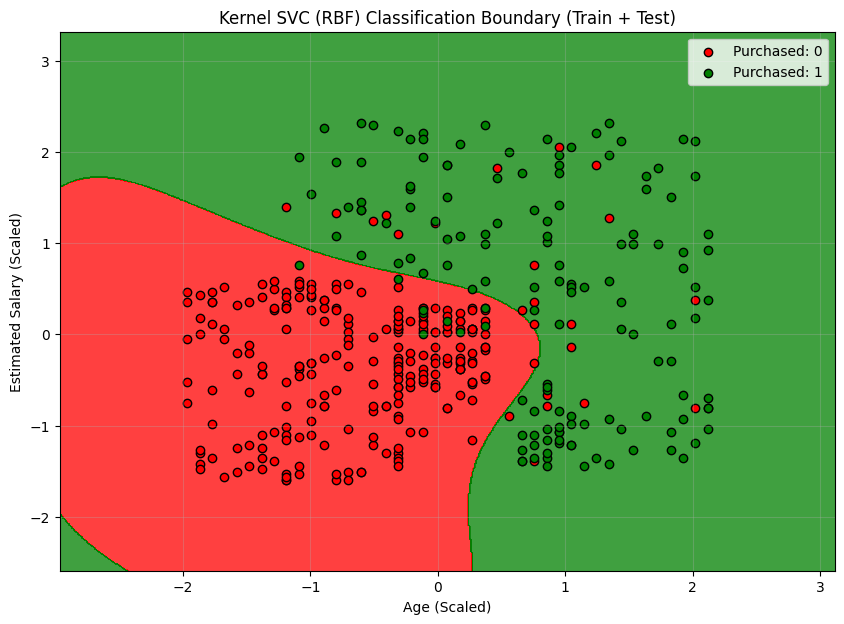

In [ ]:
#  4) visualize the model

# we will use the Kernel SVC (RBF) model for visualization as an example
model_to_visualize_name = 'Kernel SVC (RBF)'
classifier = best_estimators[model_to_visualize_name]

def plot_model_results(classifier, X_set, y_set, title_suffix):
    """
    Scatters the results, setting TP, FP, FN, TN in different colors.
    """
    y_pred = classifier.predict(X_set)

    is_true_positive = (y_set == 1) & (y_pred == 1)
    is_false_positive = (y_set == 0) & (y_pred == 1)
    is_false_negative = (y_set == 1) & (y_pred == 0)
    is_true_negative = (y_set == 0) & (y_pred == 0)

    # plotting
    plt.figure(figsize=(10, 7))

    # TP: Correctly predicted 1
    plt.scatter(X_set[is_true_positive, 0], X_set[is_true_positive, 1],
                color='green', marker='o', label='TP (Actual: Yes, Pred: Yes)')

    # FP: Incorrectly predicted 1
    plt.scatter(X_set[is_false_positive, 0], X_set[is_false_positive, 1],
                color='red', marker='s', label='FP (Actual: No, Pred: Yes)')

    # FN: Incorrectly predicted 0
    plt.scatter(X_set[is_false_negative, 0], X_set[is_false_negative, 1],
                color='orange', marker='^', label='FN (Actual: Yes, Pred: No)')

    # TN: Correctly predicted 0
    plt.scatter(X_set[is_true_negative, 0], X_set[is_true_negative, 1],
                color='blue', marker='x', label='TN (Actual: No, Pred: No)')

    plt.title(f'{model_to_visualize_name} Classification Results ({title_suffix})')
    plt.xlabel('Age (Scaled)')
    plt.ylabel('Estimated Salary (Scaled)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# i) scatter the train result
plot_model_results(classifier, X_train, y_train, 'Training Set')

# ii) scatter the test result
plot_model_results(classifier, X_test, y_test, 'Test Set')

def plot_classification_boundary(classifier, X_set, y_set, title):
    """
    Visualizes the classification boundary of the model.
    """
    X1, X2 = np.meshgrid(
        np.arange(X_set[:, 0].min() - 1, X_set[:, 0].max() + 1, step = 0.01),
        np.arange(X_set[:, 1].min() - 1, X_set[:, 1].max() + 1, step = 0.01)
    )

    # predict on  meshgrid points
    Z = classifier.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape)

    # plot the decision boundary (contour plot)
    plt.figure(figsize=(10, 7))
    plt.contourf(X1, X2, Z,
                 alpha = 0.75,
                 cmap = ListedColormap(('red', 'green')))

    # plot the original points
    for i, j in enumerate(np.unique(y_set)):
        plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                    color = ListedColormap(('red', 'green'))(i),
                    label = f'Purchased: {j}',
                    marker = 'o', edgecolors='black')

    plt.title(title)
    plt.xlabel('Age (Scaled)')
    plt.ylabel('Estimated Salary (Scaled)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# iii) visualize the classification boundary of the model
plot_classification_boundary(
    classifier,
    np.concatenate((X_train, X_test), axis=0),
    np.concatenate((y_train, y_test), axis=0),
    f'{model_to_visualize_name} Classification Boundary (Train + Test)'
)